In [59]:
import pandas as pd
import numpy as np
import jieba
import jieba.posseg as psg
from pandas import DataFrame
from sklearn.cross_validation import train_test_split
from keras.utils import plot_model
from keras.models import Sequential
from keras.layers import SimpleRNN,LSTM,GRU ,Activation, Dense ,Embedding

### Step 1 数据导入及数据预处理

#### 1.1 数据导入

In [60]:
data = pd.read_csv("data/sohu.csv")

In [61]:
data.info

<bound method DataFrame.info of          label                                               text
0          pic  高清：彭帅谢淑薇遗憾遭逆转出局 击掌互相鼓励责编:马克杰 日期:2013-10-4 彭帅谢淑...
1         news  河南周口路边秸秆燃烧 2岁幼儿被熏晕(图)  10月3日下午,崔先生驾车去周口郸城县汲冢镇走...
2         news  消息称138名中国劳工在菲律宾被抓 使馆正核实【使馆正核实情况】中国驻菲律宾大使馆发言人表示...
3         news  越南重要军事领导人武元甲大将去世 享年102岁据美国媒体10月4日报道, 越南抗法、抗美战争...
4         news  西沙搜救已发现6具遇难渔民遗体 尚有52人失踪【已发现6具遇难渔民遗体 尚有52人失踪】10...
5          pic  10月4日十佳图：李娜小德球迷抢眼 大威显文静责编:马克杰 日期:2013-10-4 小德的...
6          pic  高清：小德速胜高举双臂庆祝 鼓掌向球迷们致意责编:马克杰 日期:2013-10-4 小德鼓掌...
7       sports  卡努特伤愈将首发战辽足 斯塔诺：辽足不好对付高清:国安踩场卡努特卖力 对抗赛神勇奔跑如风 (...
8         news  美“宙斯盾”系统成功进行反导试验新华网华盛顿10月4日电(记者林小春)美国国防部4日宣布再次...
9         news  3中国建筑工俄罗斯身亡【3中国建筑工俄罗斯身亡】俄伊尔库茨克州称,4日,1名中国建筑工人从在...
10        news  山西煤矿透水事故排水5万立方米 仍有12人被困中新社汾阳10月4日电(张云)山西汾西矿业正升...
11      sports  现场：彭帅暴力发球遭无视 主裁秀中文“谢谢”北京时间9月30日消息,总奖金额为5,185,6...
12        news  扬州警方：一名游客在扬州博物馆自主坠楼身亡【一游客在扬州坠亡】扬州警方通报,今天下午4点多,...
13         pic  高清：费雷尔爆冷负黯然离场 加斯奎特潇洒回球责编:马克杰

#### 1.2 查看label类型并转换成数值型

In [62]:
data['label'].unique()

array(['pic', 'news', 'sports', 'business', 'caipiao', 'yule', 'mil',
       'cul'], dtype=object)

In [63]:
data['label'].value_counts()

news        2989
sports      1200
business    1051
pic          312
yule         185
mil           95
caipiao       45
cul           44
Name: label, dtype: int64

In [64]:
#将pic,yule,mil,caipiao,cul合并成一个新的标签：others
data['label'].replace('pic','others',inplace = True)
data['label'].replace('yule','others',inplace = True)
data['label'].replace('mil','others',inplace = True)
data['label'].replace('caipiao','others',inplace = True)
data['label'].replace('cul','others',inplace = True)

In [65]:
data['label'].value_counts()

news        2989
sports      1200
business    1051
others       681
Name: label, dtype: int64

In [66]:
#将类型映射成数字，方便处理
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(data['label'])
data['label'] = le.transform(data['label'])

In [67]:
#查看标签
label_list = list(le.classes_ )

In [68]:
label_list

['business', 'news', 'others', 'sports']

#### 1.3 对文本进行jieba分词处理并去除停用词

In [69]:
#建立停用词表
buff =[]
with open('data/stopword.txt') as fp:
    for item in fp:
        item = item.strip()
        if item not in buff:
            buff.append(item)
stopwords = buff
#print(stopwords)

In [70]:
#对文本进行分词并去除停用词
def drop_stopwords(sentences):
    words = jieba.cut(sentences,cut_all=False)
    out_text =[]
    for word in words:
        if word not in stopwords and len(word)>1:
            out_text.append(word)
    return out_text

In [71]:
data['text'] = data['text'].apply(lambda x:' '.join(drop_stopwords(x)))

In [72]:
data.head(10)

,label,text
0,2,高清 彭帅 谢淑薇 遗憾 逆转 出局 击掌 鼓励 责编 马克 日期 2013 10 彭帅 谢...
1,1,河南 周口 路边 秸秆 燃烧 幼儿 10 下午 崔先生 驾车 周口 郸城县 汲冢镇 走亲戚 ...
2,1,消息 138 中国 劳工 菲律宾 使馆 核实 使馆 核实 情况 中国 菲律宾 大使馆 发言人...
3,1,越南 军事 领导人 武元甲 大将 去世 享年 102 美国 媒体 10 报道 越南 抗法 抗...
4,1,西沙 搜救 发现 遇难 渔民 遗体 尚有 52 失踪 发现 遇难 渔民 遗体 尚有 52 失...
5,2,10 十佳 李娜 小德 球迷 抢眼 大威 文静 责编 马克 日期 2013 10 小德 支持...
6,2,高清 小德 速胜 高举 双臂 庆祝 鼓掌 球迷 致意 责编 马克 日期 2013 10 小德...
7,3,卡努特 伤愈 首发 战辽足 斯塔诺 辽足 不好 对付 高清 国安 踩场 卡努特 卖力 对抗赛...
8,1,宙斯 系统 成功 反导 试验 新华网 华盛顿 10 日电 记者 小春 美国国防部 成功 反导...
9,1,中国 建筑 俄罗斯 身亡 中国 建筑 俄罗斯 身亡 伊尔库茨克州 中国 建筑工人 在建 住宅...


### Step 2 搭建模型

#### 2.1 提取特征

In [73]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

maxlen = 100 
max_features = 10000
tokenizer = Tokenizer(max_features)
tokenizer.fit_on_texts(data['text'])
sequences = tokenizer.texts_to_sequences(data['text'])
x = pad_sequences(sequences, maxlen)

#将标签变成one-hot形式
y = to_categorical(data['label'])

In [74]:
x.shape

(5921, 100)

In [75]:
y.shape

(5921, 4)

In [76]:
# 划分训练集、测试集
from sklearn.cross_validation import train_test_split

x1_train, x1_test,y1_train,y1_test = train_test_split(x,y ,test_size=0.3)

#### 2.2 搭建模型

In [77]:
from keras.layers import LSTM

model = Sequential()
model.add(Embedding(max_features,32))
model.add(LSTM(32))
model.add(Dense(4,activation='sigmoid'))

model.compile(optimizer='rmsprop',
             loss='binary_crossentropy',
             metrics=['acc'])

history = model.fit(x1_train,y1_train,
                   epochs = 10,
                   batch_size=50,
                   validation_split=0.2)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 3315 samples, validate on 829 samples
Epoch 1/10
3315/3315 [==============================] - 3s 1ms/step - loss: 0.5000 - acc: 0.7707 - val_loss: 0.4339 - val_acc: 0.8118
Epoch 2/10
3315/3315 [==============================] - 2s 656us/step - loss: 0.4125 - acc: 0.8381 - val_loss: 0.3978 - val_acc: 0.8347
Epoch 3/10
3315/3315 [==============================] - 2s 658us/step - loss: 0.3553 - acc: 0.8538 - val_loss: 0.3484 - val_acc: 0.8543
Epoch 4/10
3315/3315 [==============================] - 2s 667us/step - loss: 0.2845 - acc: 0.8942 - val_loss: 0.2959 - val_acc: 0.8863
Epoch 5/10
3315/3315 [==============================] - 2s 648us/step - loss: 0.2407 - acc: 0.9068 - val_loss: 0.3193 - val_acc: 0.8800
Epoch 6/10
3315/3315 [==============================] - 2s 675us/step - loss: 0.1997 - acc: 0.9231 - val_loss: 0.2701 - val_acc: 0.8902
Epoch 7/10
3315/331

In [78]:
accuracy = model.evaluate(x1_test, y1_test, batch_size = 50)
print("test accuracy:{}".format(accuracy))

1777/1777 [==============================] - 0s 117us/step
test accuracy:[0.3126860215010506, 0.9040517700342362]


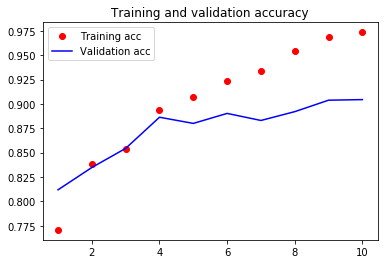

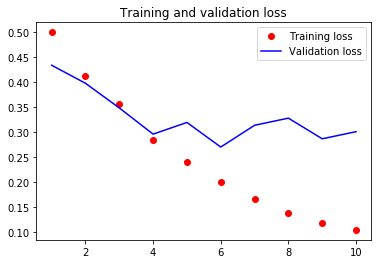

In [79]:
import matplotlib.pyplot as plt
%matplotlib inline
def plot_curve(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(1,len(acc)+1)
    
    plt.plot(epochs,acc,'bo',label='Training acc',color='red')
    plt.plot(epochs,val_acc,'b',label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    
    plt.figure()
    
    plt.plot(epochs,loss,'bo',label='Training loss',color='red')
    plt.plot(epochs,val_loss,'b',label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    
plot_curve(history)